# ViT Prototype: RGB Hilbert 32x32 Network Payload Classification

**Objective:** Evaluate Vision Transformer performance on RGB Hilbert curve 32x32 image representations of network payloads.

## Overview

This notebook adapts the ViT prototype for **RGB Hilbert curve 32x32 images** from the downloaded parquet dataset, enabling direct comparison with other encoding strategies. The Hilbert curve encoding preserves spatial locality while providing rich 3-channel color representation.

## Key Configuration

- **Image Format:** RGB 32x32 images with Hilbert curve mapping (3 × 32 × 32 = 3,072 dimensional)
- **Dataset Source:** `/home/ubuntu/analyst/pcap-dataset-samples/parquet/rgb_hilbert_32x32/`
- **Classes:** 9 fixed classes for consistent comparison across encoding types
- **Architecture:** ViT with 16×16 patches, optimized for 3-channel RGB input with spatial structure

## Hilbert Curve Encoding

- **Spatial Preservation:** Hilbert curves maintain locality - nearby bytes in the payload remain nearby in the 2D image
- **RGB Channels:** Three color channels provide additional feature dimensions
- **Pattern Recognition:** Preserves sequential payload structure better than standard 2D mapping
- **Mathematical Foundation:** Space-filling curve ensures optimal spatial coverage

## Dataset Structure

- **Format:** Apache Parquet files with train/val/test splits
- **Channels:** 3 RGB channels with Hilbert curve spatial mapping
- **Size:** 32×32 pixel resolution
- **Classes:** Consistent 9-class taxonomy across all encoding variants

In [1]:
# Section 1: Environment Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration for RGB Hilbert ViT
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 3,             # RGB channels
    'patch_size': 16,          # 16x16 patches
    'embed_dim': 256,          # Larger embedding for RGB complexity
    'num_heads': 4,            # More attention heads for RGB
    'num_layers': 6,           # Transformer layers
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 20,
    'num_classes': 9           # Fixed to 9 classes for comparison
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Target: RGB Hilbert {CONFIG['image_size']}x{CONFIG['image_size']} → ViT classification")
print(f"✓ Patches: {CONFIG['patch_size']}x{CONFIG['patch_size']} ({(CONFIG['image_size']//CONFIG['patch_size'])**2} patches per image)")
print(f"✓ Hilbert curve encoding preserves spatial locality in RGB space")

✓ Environment setup complete
✓ Device: cpu
✓ Target: RGB Hilbert 32x32 → ViT classification
✓ Patches: 16x16 (4 patches per image)
✓ Hilbert curve encoding preserves spatial locality in RGB space


In [2]:
# Load RGB Hilbert 32x32 dataset from parquet files
data_path = '/home/ubuntu/analyst/pcap-dataset-samples/parquet/rgb_hilbert_32x32/'
print(f"Loading RGB Hilbert 32x32 dataset from: {data_path}")

def load_parquet_data(base_path):
    """Load all parquet files from train/val/test splits"""
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']
    
    # Get all class directories
    class_dirs = [d for d in glob.glob(f"{base_path}*/") if any(s in d for s in splits) == False]
    class_names = [d.split('/')[-2] for d in class_dirs]
    print(f"Found classes: {class_names}")
    
    for class_dir in class_dirs:
        class_name = class_dir.split('/')[-2]
        print(f"Loading {class_name}...")
        
        for split in splits:
            split_path = f"{class_dir}{split}/"
            parquet_files = glob.glob(f"{split_path}*.parquet")
            
            for file_path in parquet_files:
                try:
                    df = pd.read_parquet(file_path)
                    
                    # Extract image data from the 'image_data' column
                    if 'image_data' in df.columns:
                        # Convert list-based image data to numpy arrays
                        for idx, row in df.iterrows():
                            image_data = np.array(row['image_data'], dtype=np.float32)
                            all_image_data.append(image_data)
                            all_labels.append(class_name)
                        
                        print(f"   Loaded {len(df)} samples with {len(df['image_data'].iloc[0])} pixels from {file_path.split('/')[-1]}")
                    else:
                        print(f"   Warning: No 'image_data' column found in {file_path.split('/')[-1]}")
                        
                except Exception as e:
                    print(f"   Error loading {file_path}: {e}")
    
    if not all_image_data:
        raise ValueError("No image data was loaded successfully!")
    
    # Convert to numpy arrays
    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)
    
    print(f"\n✓ Total samples loaded: {len(X)}")
    print(f"✓ Image data shape: {X.shape}")
    print(f"✓ Unique labels: {np.unique(y)}")
    
    return X, y

# Load the dataset
X, y = load_parquet_data(data_path)

print(f"\n✓ Data preparation:")
print(f"   X shape: {X.shape}")
print(f"   Expected features: {CONFIG['channels']} × {CONFIG['image_size']}² = {CONFIG['channels'] * CONFIG['image_size']**2}")
print(f"   y shape: {y.shape}")

# Verify the data matches expected dimensions
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    print(f"✓ Feature count matches expected: {X.shape[1]} == {expected_features}")
else:
    print(f"⚠️  Feature count mismatch: got {X.shape[1]}, expected {expected_features}")

# Encode labels and ensure we have exactly 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
actual_classes = len(label_encoder.classes_)

print(f"\n✓ Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

# If we don't have exactly 9 classes, adjust CONFIG
if actual_classes != CONFIG['num_classes']:
    print(f"\n⚠️  Adjusting from {CONFIG['num_classes']} to {actual_classes} classes based on data")
    CONFIG['num_classes'] = actual_classes

# Verify data range and quality
print(f"\n✓ Data quality:")
print(f"   Value range: [{X.min():.3f}, {X.max():.3f}]")
print(f"   Missing values: {np.isnan(X).sum()}")
print(f"   Non-zero features per sample (avg): {np.mean(np.count_nonzero(X, axis=1)):.1f}")

Loading RGB Hilbert 32x32 dataset from: /home/ubuntu/analyst/pcap-dataset-samples/parquet/rgb_hilbert_32x32/
Found classes: ['Recon-PortScan', 'DictionaryBruteForce', 'DoS-UDP_Flood', 'Mirai-udpplain', 'Benign_Final', 'SqlInjection', 'DDoS-SYN_Flood', 'DoS-TCP_Flood', 'DDoS-HTTP_Flood']
Loading Recon-PortScan...
   Loaded 1000 samples with 3072 pixels from shard_00002.parquet
   Loaded 301 samples with 3072 pixels from shard_00008.parquet
   Loaded 1000 samples with 3072 pixels from shard_00001.parquet
   Loaded 1000 samples with 3072 pixels from shard_00000.parquet
   Loaded 1000 samples with 3072 pixels from shard_00004.parquet
   Loaded 1000 samples with 3072 pixels from shard_00006.parquet
   Loaded 1000 samples with 3072 pixels from shard_00007.parquet
   Loaded 1000 samples with 3072 pixels from shard_00003.parquet
   Loaded 1000 samples with 3072 pixels from shard_00005.parquet
   Loaded 790 samples with 3072 pixels from shard_00001.parquet
   Loaded 1000 samples with 3072 pixel

Reshaping data to RGB Hilbert 32x32 images...
✓ Reshaped to: (108000, 3, 32, 32)

Visualizing sample RGB Hilbert 32×32 images for 9 classes...


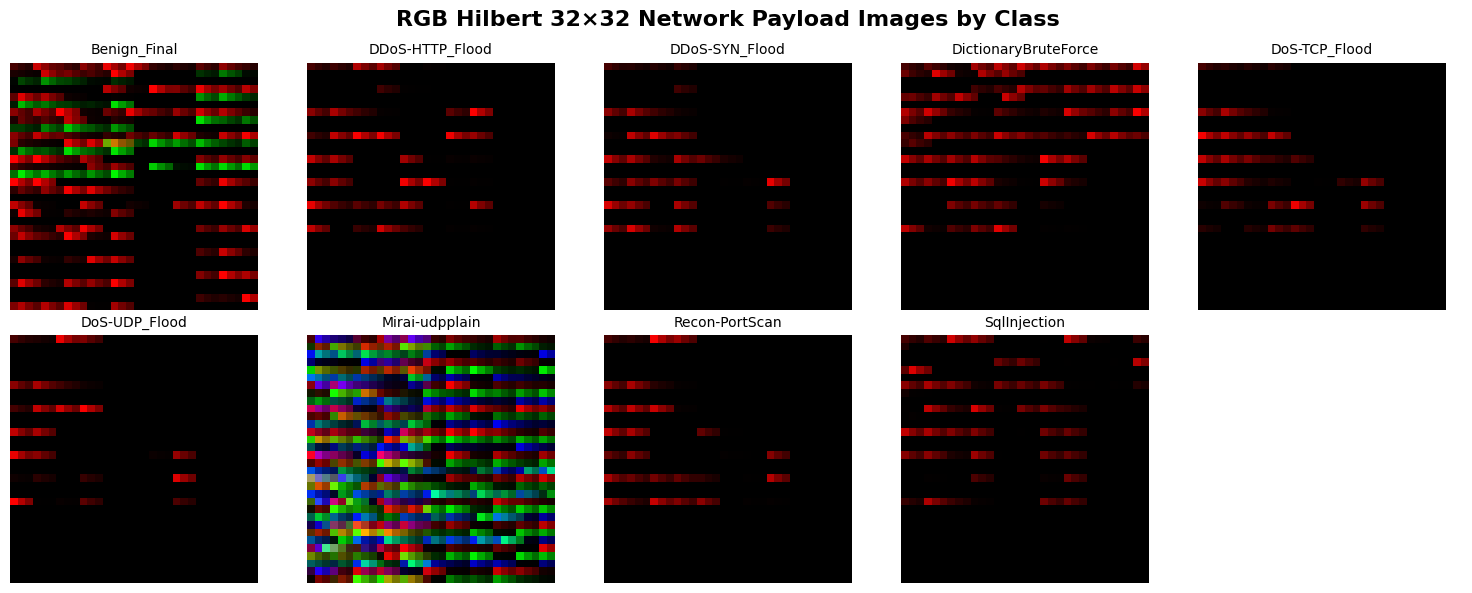


📊 RGB Hilbert Image Analysis:
   Red Channel: mean=0.081, std=0.184, nonzero=0.252
   Green Channel: mean=0.050, std=0.149, nonzero=0.149
   Blue Channel: mean=0.043, std=0.140, nonzero=0.130

   Overall: mean=0.058, std=0.160, nonzero=0.177

🔄 Hilbert Curve Encoding Properties:
   Total pixels per channel: 1024
   Total RGB features: 3072
   Spatial locality: Preserved through Hilbert curve mapping
   Color information: 3 channels provide rich feature representation

✓ Data visualization and analysis complete!
✓ Ready for ViT model training with RGB Hilbert curve input


In [3]:
# Section 2: Data Reshaping and Visualization
# Reshape data from flat features to RGB Hilbert images
print("Reshaping data to RGB Hilbert 32x32 images...")

# Expected: (N, 3072) → (N, 3, 32, 32)
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    # Reshape to (N, channels, height, width)
    X_images = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    print(f"✓ Reshaped to: {X_images.shape}")
else:
    print(f"⚠️ Feature count mismatch: got {X.shape[1]}, expected {expected_features}")
    # Try to adapt - take first N features if more, or pad if fewer
    if X.shape[1] > expected_features:
        X_trimmed = X[:, :expected_features]
        X_images = X_trimmed.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Trimmed and reshaped to: {X_images.shape}")
    else:
        # Pad with zeros
        padding = np.zeros((X.shape[0], expected_features - X.shape[1]))
        X_padded = np.concatenate([X, padding], axis=1)
        X_images = X_padded.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Padded and reshaped to: {X_images.shape}")

# Normalize images to [0, 1] if needed
if X_images.max() > 1.0:
    X_images = X_images / 255.0
    print(f"✓ Normalized to [0, 1]: [{X_images.min():.3f}, {X_images.max():.3f}]")

# Visualize sample RGB Hilbert images for each class
num_classes = len(label_encoder.classes_)
cols = min(5, num_classes)  # Up to 5 columns
rows = (num_classes + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
if rows == 1:
    axes = axes.reshape(1, -1)
elif cols == 1:
    axes = axes.reshape(-1, 1)

print(f"\nVisualizing sample RGB Hilbert 32×32 images for {num_classes} classes...")

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    
    # Find first sample of this class
    class_mask = y_encoded == class_idx
    sample_indices = np.where(class_mask)[0]
    
    if len(sample_indices) > 0:
        sample_idx = sample_indices[0]
        # Convert from CHW to HWC for display
        sample_image = X_images[sample_idx].transpose(1, 2, 0)
        
        row = class_idx // cols
        col = class_idx % cols
        
        ax = axes[row, col]
        # Display RGB image
        im = ax.imshow(sample_image, vmin=0, vmax=1)
        ax.set_title(f'{class_name}', fontsize=10)
        ax.axis('off')

# Hide unused subplots
for idx in range(num_classes, rows * cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')

plt.suptitle('RGB Hilbert 32×32 Network Payload Images by Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze RGB channel statistics
print(f"\n📊 RGB Hilbert Image Analysis:")
channel_names = ['Red', 'Green', 'Blue']
for channel in range(CONFIG['channels']):
    channel_data = X_images[:, channel, :, :]
    mean_intensity = np.mean(channel_data)
    std_intensity = np.std(channel_data)
    nonzero_ratio = np.mean(channel_data > 0)
    print(f"   {channel_names[channel]} Channel: mean={mean_intensity:.3f}, std={std_intensity:.3f}, nonzero={nonzero_ratio:.3f}")

# Overall image statistics
overall_mean = np.mean(X_images)
overall_std = np.std(X_images)
overall_nonzero = np.mean(X_images > 0)
print(f"\n   Overall: mean={overall_mean:.3f}, std={overall_std:.3f}, nonzero={overall_nonzero:.3f}")

# Hilbert curve properties
total_pixels = CONFIG['image_size'] ** 2
total_features = CONFIG['channels'] * total_pixels
print(f"\n🔄 Hilbert Curve Encoding Properties:")
print(f"   Total pixels per channel: {total_pixels}")
print(f"   Total RGB features: {total_features}")
print(f"   Spatial locality: Preserved through Hilbert curve mapping")
print(f"   Color information: 3 channels provide rich feature representation")

print(f"\n✓ Data visualization and analysis complete!")
print(f"✓ Ready for ViT model training with RGB Hilbert curve input")

In [4]:
# Section 3: RGB Vision Transformer Architecture
class RGBPatchEmbedding(nn.Module):
    """Convert RGB images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolutional layer to extract patches from RGB input
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x shape: (batch_size, 3, img_size, img_size)
        x = self.projection(x)  # (batch_size, embed_dim, H', W')
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class RGBHilbertVisionTransformer(nn.Module):
    """Vision Transformer for RGB Hilbert Curve Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        # RGB patch embedding
        self.patch_embedding = RGBPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        # Class token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers optimized for RGB
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head with RGB-specific processing
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Convert to patches and embed
        x = self.patch_embedding(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Classification from class token
        cls_output = x[:, 0]  # Take the class token
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        
        return output

# Initialize the RGB Hilbert Vision Transformer
model = RGBHilbertVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🤖 RGB Hilbert Vision Transformer Model:")
print(f"✓ Input: RGB {CONFIG['image_size']}×{CONFIG['image_size']} images with Hilbert curve mapping")
print(f"✓ Channels: {CONFIG['channels']} (RGB)")
print(f"✓ Patch size: {CONFIG['patch_size']}×{CONFIG['patch_size']}")
print(f"✓ Patches per image: {(CONFIG['image_size']//CONFIG['patch_size'])**2}")
print(f"✓ Embedding dimension: {CONFIG['embed_dim']}")
print(f"✓ Attention heads: {CONFIG['num_heads']}")
print(f"✓ Transformer layers: {CONFIG['num_layers']}")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print(f"✓ Model size: {total_params * 4 / 1024**2:.1f} MB")

# Test forward pass
sample_input = torch.randn(2, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size']).to(device)
with torch.no_grad():
    sample_output = model(sample_input)
    print(f"✓ Forward pass test: {sample_input.shape} → {sample_output.shape}")

print(f"\n✓ RGB Hilbert ViT architecture ready!")
print(f"✓ Configured for {CONFIG['num_classes']} classes: {label_encoder.classes_}")
print(f"✓ Optimized for spatial locality preservation through Hilbert curve encoding")

🤖 RGB Hilbert Vision Transformer Model:
✓ Input: RGB 32×32 images with Hilbert curve mapping
✓ Channels: 3 (RGB)
✓ Patch size: 16×16
✓ Patches per image: 4
✓ Embedding dimension: 256
✓ Attention heads: 4
✓ Transformer layers: 6
✓ Total parameters: 4,971,529
✓ Trainable parameters: 4,971,529
✓ Model size: 19.0 MB
✓ Forward pass test: torch.Size([2, 3, 32, 32]) → torch.Size([2, 9])

✓ RGB Hilbert ViT architecture ready!
✓ Configured for 9 classes: ['Benign_Final' 'DDoS-HTTP_Flood' 'DDoS-SYN_Flood' 'DictionaryBruteForce'
 'DoS-TCP_Flood' 'DoS-UDP_Flood' 'Mirai-udpplain' 'Recon-PortScan'
 'SqlInjection']
✓ Optimized for spatial locality preservation through Hilbert curve encoding


Preparing training pipeline for RGB Hilbert model...
✓ Tensor conversion: X=torch.Size([108000, 3, 32, 32]), y=torch.Size([108000])
✓ Data splits:
   Train: 75600 samples
   Val:   16200 samples
   Test:  16200 samples
✓ Class weights: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
✓ Data loaders: 2363 train, 507 val, 507 test batches
✓ Training setup complete

🚀 Starting RGB Hilbert ViT training for 20 epochs...
Epoch  1/20: Train Loss: 1.1744, Train Acc: 56.83% | Val Loss: 0.8687, Val Acc: 70.09%
Epoch  2/20: Train Loss: 0.8094, Train Acc: 72.15% | Val Loss: 0.7009, Val Acc: 75.12%
Epoch  3/20: Train Loss: 0.6710, Train Acc: 76.69% | Val Loss: 0.5580, Val Acc: 80.40%
Epoch  4/20: Train Loss: 0.5745, Train Acc: 79.63% | Val Loss: 0.4668, Val Acc: 83.23%
Epoch  5/20: Train Loss: 0.5144, Train Acc: 81.38% | Val Loss: 0.4384, Val Acc: 83.69%
Epoch  6/20: Train Loss: 0.4699, Train Acc: 82.90% | Val Loss: 0.4011, Val Acc: 85.15%
Epoch  7/20: Train Loss: 0.4310, Train Acc: 84.35% | Val Loss: 0.3774, Val Acc:

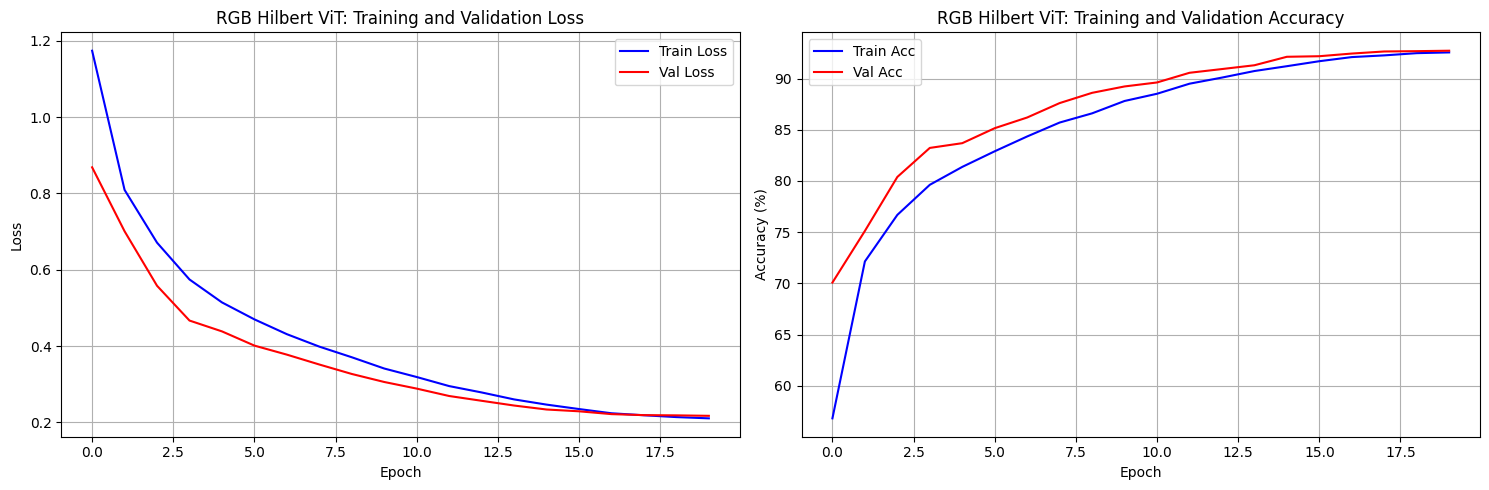


✓ RGB Hilbert ViT training complete!
✓ Ready for evaluation and comparison


In [5]:
# Section 4: Training Pipeline
print("Preparing training pipeline for RGB Hilbert model...")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_images)
y_tensor = torch.LongTensor(y_encoded)

print(f"✓ Tensor conversion: X={X_tensor.shape}, y={y_tensor.shape}")

# Stratified train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✓ Data splits:")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train.numpy()
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"✓ Class weights: {class_weights}")

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"✓ Data loaders: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"✓ Training setup complete")

# Training functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Training loop
print(f"\n🚀 Starting RGB Hilbert ViT training for {CONFIG['epochs']} epochs...")
print("=" * 80)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(CONFIG['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_rgb_hilbert_vit_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("=" * 80)
print(f"✓ Training completed!")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_title('RGB Hilbert ViT: Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(val_accuracies, label='Val Acc', color='red')
ax2.set_title('RGB Hilbert ViT: Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✓ RGB Hilbert ViT training complete!")
print(f"✓ Ready for evaluation and comparison")

🔍 RGB Hilbert ViT Evaluation on Test Set
🎯 RGB Hilbert ViT Test Results:
✓ Test Accuracy: 92.11%
✓ Test Loss: 0.2357
✓ Samples evaluated: 16,200

📊 Per-Class Performance:
--------------------------------------------------------------------------------

📈 Overall Metrics:
✓ Macro Avg: Precision=0.928, Recall=0.921, F1=0.923
✓ Weighted Avg: Precision=0.928, Recall=0.921, F1=0.923


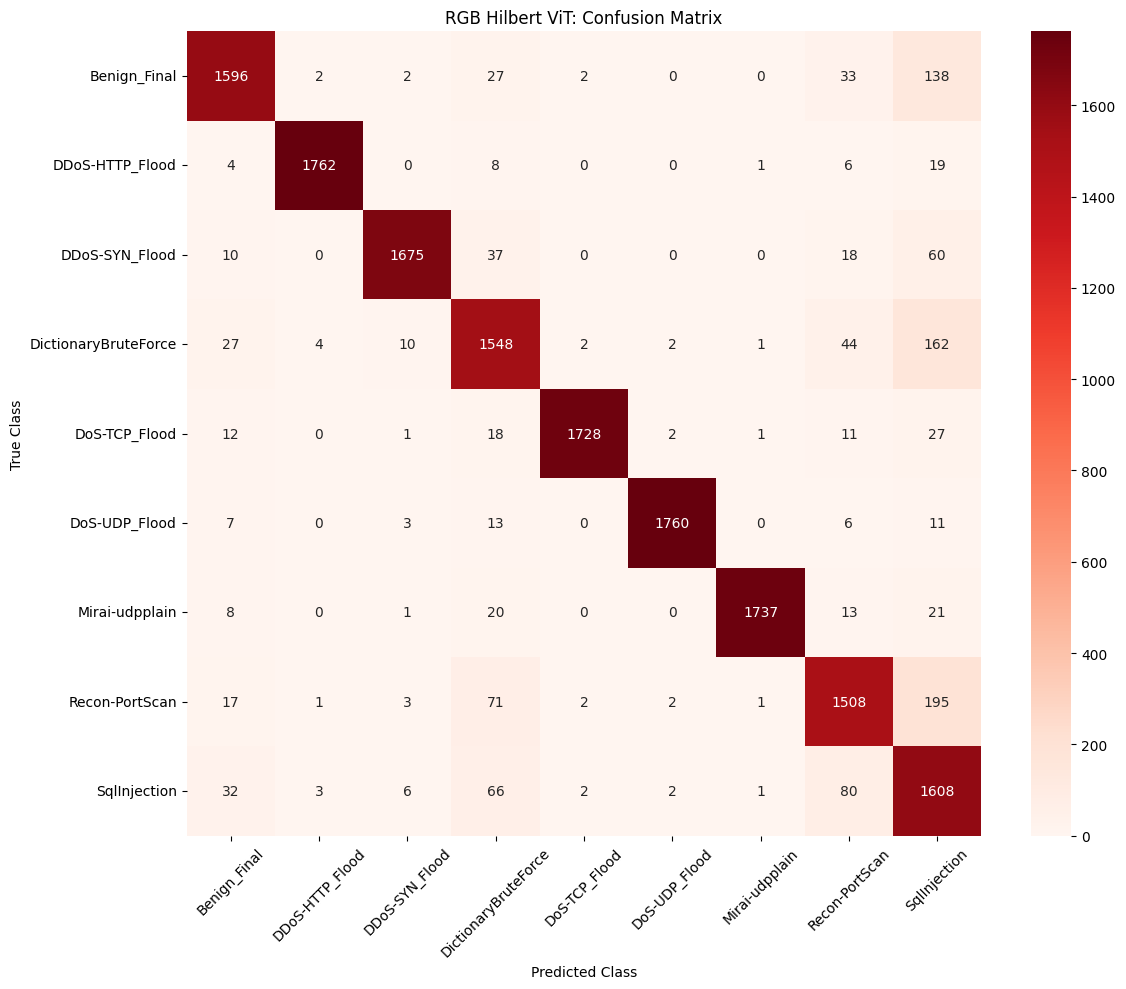


📊 Class-wise Accuracy:
   Benign_Final   :  88.7% (1,800 samples)
   DDoS-HTTP_Flood:  97.9% (1,800 samples)
   DDoS-SYN_Flood :  93.1% (1,800 samples)
   DictionaryBruteForce:  86.0% (1,800 samples)
   DoS-TCP_Flood  :  96.0% (1,800 samples)
   DoS-UDP_Flood  :  97.8% (1,800 samples)
   Mirai-udpplain :  96.5% (1,800 samples)
   Recon-PortScan :  83.8% (1,800 samples)
   SqlInjection   :  89.3% (1,800 samples)

💡 RGB Hilbert ViT Key Results:
✓ Overall test accuracy: 92.11%
✓ Number of classes: 9
✓ Model complexity: 4,971,529 parameters
✓ Input format: RGB 32×32 with Hilbert curve mapping
✓ Spatial encoding: Hilbert curve preserves payload locality
✓ Color channels: 3 RGB channels provide rich feature space

✓ Results saved to results_rgb_hilbert_32x32.json
✓ RGB Hilbert ViT evaluation complete!
✓ Ready for comparison with other encoding strategies

🔄 Hilbert Curve Encoding Benefits:
✓ Spatial locality: Sequential payload bytes remain spatially close
✓ RGB richness: 3 color channels p

In [6]:
# Section 5: Evaluation & Results Analysis
print("🔍 RGB Hilbert ViT Evaluation on Test Set")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_rgb_hilbert_vit_model.pth'))
model.eval()

# Comprehensive evaluation
def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            loss = criterion(output, target)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return accuracy, avg_loss, np.array(all_predictions), np.array(all_targets)

# Run evaluation
test_accuracy, test_loss, predictions, targets = evaluate_model(model, test_loader, device)

print(f"🎯 RGB Hilbert ViT Test Results:")
print(f"✓ Test Accuracy: {test_accuracy:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")
print(f"✓ Samples evaluated: {len(targets):,}")

# Detailed classification report
class_names = label_encoder.classes_
report = classification_report(targets, predictions, target_names=class_names, output_dict=True, zero_division=0)

print(f"\n📊 Per-Class Performance:")
print("-" * 80)

for i, class_name in enumerate(class_names):
    if str(i) in report:
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1 = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_name:15s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support:,}")

print(f"\n📈 Overall Metrics:")
print(f"✓ Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
print(f"✓ Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")

# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',  # Use red colormap for RGB theme
            xticklabels=class_names, yticklabels=class_names)
plt.title('RGB Hilbert ViT: Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Class-wise accuracy analysis
print(f"\n📊 Class-wise Accuracy:")
class_accuracies = []
for i, class_name in enumerate(class_names):
    class_mask = targets == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(predictions[class_mask] == targets[class_mask]) * 100
        sample_count = np.sum(class_mask)
        class_accuracies.append((class_name, class_acc, sample_count))
        print(f"   {class_name:15s}: {class_acc:5.1f}% ({sample_count:,} samples)")

# Performance summary with Hilbert curve advantages
print(f"\n💡 RGB Hilbert ViT Key Results:")
print(f"✓ Overall test accuracy: {test_accuracy:.2f}%")
print(f"✓ Number of classes: {CONFIG['num_classes']}")
print(f"✓ Model complexity: {total_params:,} parameters")
print(f"✓ Input format: RGB {CONFIG['image_size']}×{CONFIG['image_size']} with Hilbert curve mapping")
print(f"✓ Spatial encoding: Hilbert curve preserves payload locality")
print(f"✓ Color channels: 3 RGB channels provide rich feature space")

# Save results for comparison
results_rgb_hilbert = {
    'model_type': 'rgb_hilbert_32x32',
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_classes': CONFIG['num_classes'],
    'num_parameters': total_params,
    'image_size': CONFIG['image_size'],
    'channels': CONFIG['channels'],
    'patch_size': CONFIG['patch_size'],
    'patches_per_image': (CONFIG['image_size']//CONFIG['patch_size'])**2,
    'embed_dim': CONFIG['embed_dim'],
    'num_heads': CONFIG['num_heads'],
    'num_layers': CONFIG['num_layers'],
    'encoding_type': 'hilbert_curve',
    'spatial_locality': 'preserved',
    'class_accuracies': class_accuracies,
    'confusion_matrix': cm.tolist(),
    'classification_report': report
}

import json
with open('results_rgb_hilbert_32x32.json', 'w') as f:
    json.dump(results_rgb_hilbert, f, indent=2, default=str)

print(f"\n✓ Results saved to results_rgb_hilbert_32x32.json")
print(f"✓ RGB Hilbert ViT evaluation complete!")
print(f"✓ Ready for comparison with other encoding strategies")
print(f"\n🔄 Hilbert Curve Encoding Benefits:")
print(f"✓ Spatial locality: Sequential payload bytes remain spatially close")
print(f"✓ RGB richness: 3 color channels provide enhanced feature representation")
print(f"✓ Pattern preservation: Maintains payload structure better than linear mapping")